In [9]:
import binpacking
import random
import time
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

seeds = (260, 102018, 27)
names = ["NextFit", "FirstFit", "BestFit", "FirstFitDec", "BestFitDec", "CustomFit"]

packer = [None]*6
packer[0] = binpacking.NextFit()
packer[1] = binpacking.FirstFit()
packer[2] = binpacking.BestFit()
packer[3] = binpacking.FirstFitDec()
packer[4] = binpacking.BestFitDec()
packer[5] = binpacking.CustomFit()

NUM_EXP = 9
data = []
perf_data = {name: [] for name in names}
results = []


for seed in seeds:
    random.seed(seed)
    DATA_SIZE = 50
    for j in range(NUM_EXP):
        DATA_SIZE = DATA_SIZE * 2
        data = []
        for i in range(DATA_SIZE):
            data.append(round(random.uniform(0.0, 0.8), 8))
        data_save = data.copy()

        for i in range(len(packer)):
            packer[i].reset()
            data = data_save.copy()
            waste, running_time = packer[i].measure(data)

            results.append({
                            "Seed": seed,
                            "N": DATA_SIZE,
                            "Algorithm": names[i],
                            "Waste": waste,
                            "Runtime": running_time
                        })
            
df_results = pd.DataFrame(results)

NextFit Regression Equation: $y = 0.17x^{0.98}$
FirstFit Regression Equation: $y = 0.16x^{0.68}$
BestFit Regression Equation: $y = 0.12x^{0.68}$
FirstFitDec Regression Equation: $y = 1.02x^{0.06}$
BestFitDec Regression Equation: $y = 1.02x^{0.06}$
CustomFit Regression Equation: $y = 0.35x^{0.51}$


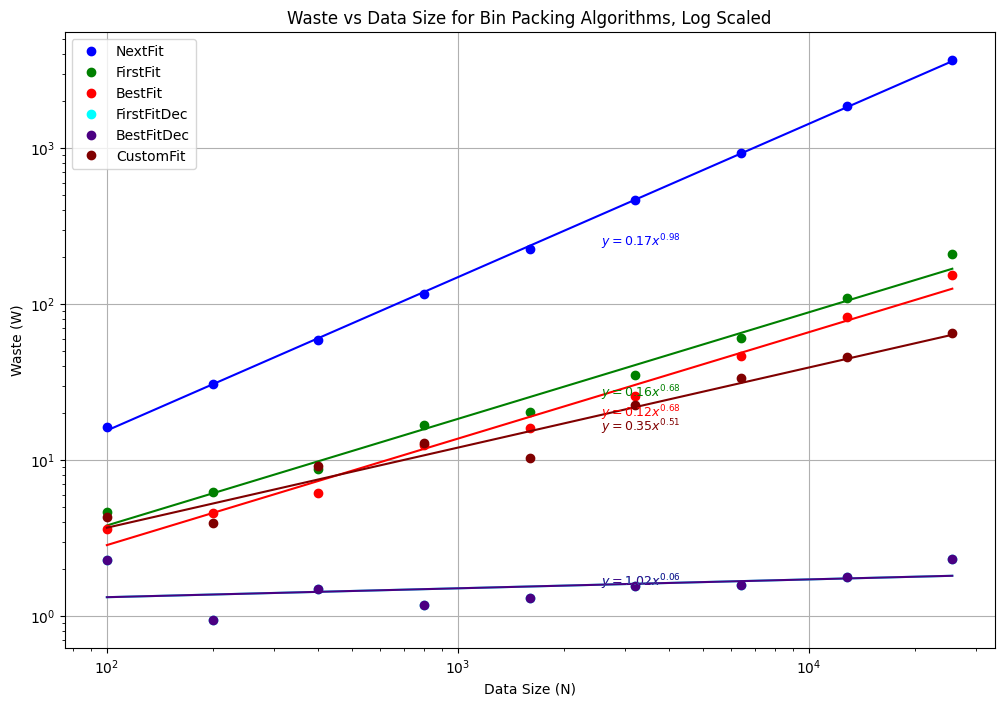

In [11]:
plt.figure(figsize=(12, 8))

data_sizes = np.unique(df_results['N'])

# Predefined list of colors for each algorithm
colors = ['blue', 'green', 'red', 'cyan', 'indigo', 'maroon']

for name, color in zip(names, colors):
    algorithm_data = df_results[df_results['Algorithm'] == name]
    mean_waste = algorithm_data.groupby('N')['Waste'].mean().reindex(data_sizes)
    
    log_n = np.log(data_sizes)
    log_waste = np.log(mean_waste)
    
    coefficients = np.polyfit(log_n, log_waste, 1)
    slope = coefficients[0]
    intercept = np.exp(coefficients[1])  # Exponentiating the intercept
    
    poly = np.poly1d(coefficients)
    fit_values = np.exp(poly(log_n))
    
    # Plot with specified colors
    plt.plot(data_sizes, mean_waste, 'o', color=color, label=name)
    plt.plot(data_sizes, fit_values, '-', color=color)  # Use the same color for the fit line
    
    # Equation of the regression line
    equation = f'$y = {intercept:.2f}x^{{{slope:.2f}}}$'
    print(f"{name} Regression Equation: {equation}")
    
    # Optional: Annotate the equation on the plot
    x_pos = data_sizes.max()/10
    y_pos = fit_values[len(fit_values) // 2]
    plt.text(x_pos, y_pos, equation, fontsize=9, color=color)  # Match text color

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Data Size (N)')
plt.ylabel('Waste (W)')
plt.title('Waste vs Data Size for Bin Packing Algorithms, Log Scaled')
plt.legend()
plt.grid(True)
plt.show()

NextFit Regression Equation: $y = 0.00x^{1.27}$
FirstFit Regression Equation: $y = 0.00x^{2.02}$
BestFit Regression Equation: $y = 0.00x^{1.96}$
FirstFitDec Regression Equation: $y = 0.00x^{2.04}$
BestFitDec Regression Equation: $y = 0.00x^{1.99}$
CustomFit Regression Equation: $y = 0.00x^{1.02}$


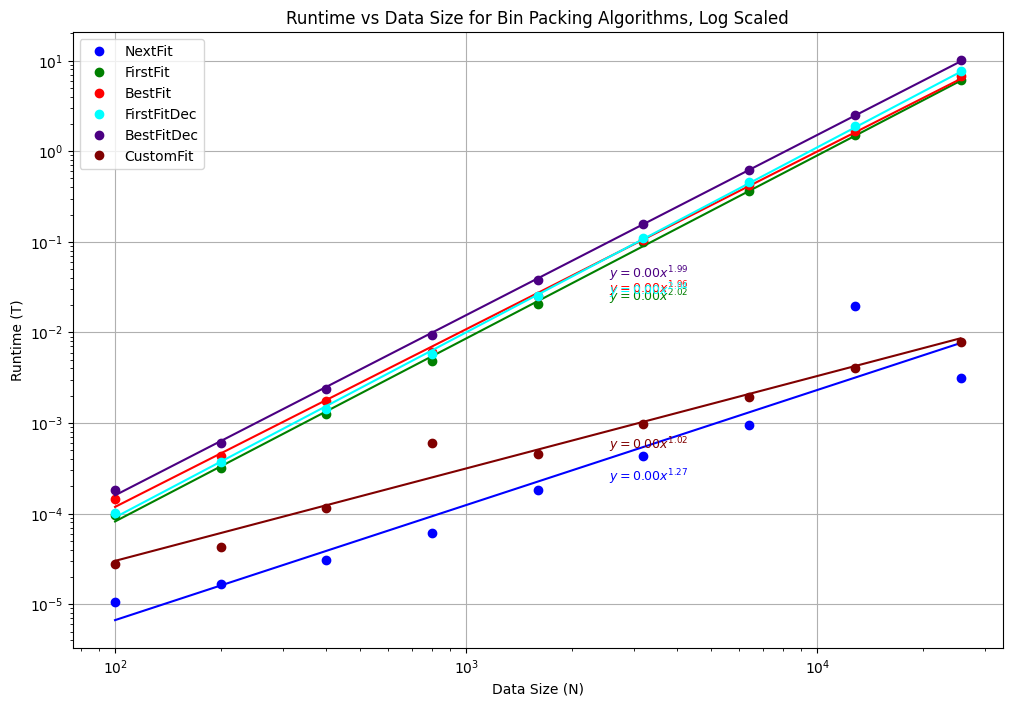

In [10]:
plt.figure(figsize=(12, 8))

data_sizes = np.unique(df_results['N'])

# Predefined list of colors for each algorithm
colors = ['blue', 'green', 'red', 'cyan', 'indigo', 'maroon']

for name, color in zip(names, colors):
    algorithm_data = df_results[df_results['Algorithm'] == name]
    mean_runtime = algorithm_data.groupby('N')['Runtime'].mean().reindex(data_sizes)
    
    log_n = np.log(data_sizes)
    log_runtime = np.log(mean_runtime)
    
    coefficients = np.polyfit(log_n, log_runtime, 1)
    slope = coefficients[0]
    intercept = np.exp(coefficients[1])  # Exponentiating the intercept
    
    poly = np.poly1d(coefficients)
    fit_values = np.exp(poly(log_n))
    
    # Plot with specified colors
    plt.plot(data_sizes, mean_runtime, 'o', color=color, label=name)
    plt.plot(data_sizes, fit_values, '-', color=color)  # Use the same color for the fit line
    
    # Equation of the regression line
    equation = f'$y = {intercept:.2f}x^{{{slope:.2f}}}$'
    print(f"{name} Regression Equation: {equation}")
    
    # Optional: Annotate the equation on the plot
    x_pos = data_sizes.max()/10
    y_pos = fit_values[len(fit_values) // 2]
    plt.text(x_pos, y_pos, equation, fontsize=9, color=color)  # Match text color

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Data Size (N)')
plt.ylabel('Runtime (T)')
plt.title('Runtime vs Data Size for Bin Packing Algorithms, Log Scaled')
plt.legend()
plt.grid(True)
plt.show()

# Report
## Custom Packing Algorithm Choice: NextFit, Decreasing, With Two Pointers

Our custom packing algorithm takes advantage of the fact that our data is uniformly distributed. We use NextFit, but we reverse-sort the data as in the BestFit and FirstFit Decreasing algorithms. Then, we align a buffer pointer with the last index in the data - the smallest value. We use a two-pointer approach to 'zipper' pack the data, first checking the largest value, then checking the lowest value, and bringing the two pointers together toward the center of the dataset. <br>

This was initially tested with randomly generated values from 0 to 1 - the maximum size of the bin - and it performed just as well as BFD and FFD. However, the transition to max data sizes below the capacity of the bin proved a massive performance impact because this would wind up taking the first value, then many of the small values, and so on... <br>

To fix this, we instead split the data into two envelopes. The first envelope is found by bringing the low-value pointer up the dataset until it finds a value that would overflow a bin when added to the largest value. It then takes one step back - this demarcates the first envelope and the algorithm packs the first set. Then, the remaining values are folded into bins the same way. <br>

This two-envelope approach claws back the majorty of the performance gain over normal NextFit, and results in the CustomFit performing better than anything other than BFD and FFD in terms of waste. When it comes to runtime, however, our CustomFit ran dramatically faster than every algorithm other than NextFit. <br>

In the end, using NextFit as a baseline for performance, and considering BFD/FFD as an optimal case, our CustomFit performs 98.7% as well as BFD/FFD in terms of waste, but does so 127,441.01% faster. <br>

## Waste per Algorithm, as a Function of Data Size (Log-Scaled)

First, let us consider the Waste of each binpacking algorithm.

| Algorithm | W(A) Function (Log-Scaled) | Big-O |
| --- | --- | --- |
| NextFit | $y = 0.17x^{0.98}$ | $O(nlog(n))/O(n)$ |
| FirstFit | $y = 0.16x^{0.68}$| $O(nlog(n))$ |
| BestFit | $y = 0.12x^{0.68}$ | $O(nlog(n))$ |
| FirstFitDec | $y = 1.02x^{0.06}$ | $O(log(n))$ |
| BestFitDec | $y = 1.02x^{0.06}$ | $O(log(n))$ |
| CustomFit | $y = 0.35x^{0.51}$ | $O(nlog(n))$ |

For our purposes, there are three distinct tiers of performance. NextFit's waste values continue to grow at almost-linear rates with data size. FirstFit, BestFit, and our CustomFit all grow more slowly, but still above constant or log(n). The two decreasing algorithms barely grow at all, close to O(1).

## Runtime per Algorithm, as a Function of Data Size (Log-Scaled)

Now, we consider the log-scaled runtime results.

| Algorithm | Runtime (sec) | Big-O |
| --- | --- | --- |
| NextFit | $y = 0.00x^{1.27}$ | $O(log(n))$ |
| FirstFit | $y = 0.00x^{2.02}$| $O(nlog(n))$ |
| BestFit | $y = 0.00x^{1.96}$ | $O(nlog(n))$ |
| FirstFitDec | $y = 0.00x^{2.04}$ | $O(nlog(n))$ |
| BestFitDec | $y = 0.00x^{1.99}$| $O(nlog(n))$ |
| CustomFit | $y = 0.00x^{1.02}$ | $O(log(n))$ |

Here, we see two clusters of performance. NextFit and CustomFit perform notably faster than the other four algorithms. This isn't altogether helpful for NextFit, whose waste values render it almost a non-competitor, but our CustomFit outperforms anything but BFD and FFD with regard to waste while also maintaining the speed benefit of NextFit. Bringing this into further emprirical context, let's consider the case at seed 260 and $N = 25,600$, where we treat NextFit's waste as a baseline to improve upon:

| Algorithm | Runtime (sec) | Waste Improvement (Relative to NextFit) |
| --- | --- | --- |
| BestFitDecreasing | $10.030882$ | $3662.0\ (100\%)$ |
| CustomFit | $0.007871$| $3599.0\ (98.7\%) $ |

From an implementation standpoint, this begs that in a production environment, an analysis of cost-benefit for one's compute and storage resources needs to be completed before settling on an algorithm for storing data. Given the performance delta in terms of speed, allowing greater waste might be an example of 'perfect being the enemy of good enough'. Situations where the extra efficiency is required are easy to imagine, however - just considering onboard computers in drones, or at even smaller scale, the microcontrollers in manufacturing settings, might both gladly trade speed for memory compactness.